In [7]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from frouros.detectors.concept_drift import DDM, DDMConfig
from frouros.metrics import PrequentialError
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LinearRegression

np.random.seed(seed=31)

In [8]:
data = pd.read_csv('EODHD_EURUSD_HISTORICAL_2019_2024_1min.csv').head(100000)
data = data[['close']]
data = np.log(data / data.shift(1))
data = data.dropna()
scaler = StandardScaler()
scaled_result = scaler.fit_transform(data.values.reshape(-1, 1))
data['close'] = pd.Series(scaled_result.flatten())
data['target'] = data['close'].shift(-1).dropna()
print(data['target'].head())
data = data.dropna()

1   -0.256345
2    0.345629
3    2.151277
4   -1.288079
5    0.947458
Name: target, dtype: float64


In [9]:
X = data[['close']].values
y = data['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.99, random_state=31)

In [14]:
model=SVR()
model.fit(X_train, y_train)

SVR()

In [11]:
config = DDMConfig(
    warning_level=2.6,
    drift_level=2.7,
    min_num_instances=1,  
)
detector = DDM(config=config)
metric = PrequentialError(alpha=1.0) 

In [12]:
def stream_test(X_test, y_test, y, metric, detector):
    drift_points = []
    for i, (X, y) in enumerate(zip(X_test, y_test)):
        y_pred = model.predict(X.reshape(1, -1))
        error = 1 - (y_pred.item() == y.item())
        metric_error = metric(error_value=error)      
        _ = detector.update(value=error)
        status = detector.status        
        if status["drift"]:  
            drift_points.append(i)  
            print(f"Concept drift detected at step {i}. Accuracy: {1 - metric_error:.4f}")
    if not drift_points:
        print("No concept drift detected")  
        
    print(f"Final accuracy: {1 - metric_error:.4f}\n")
    
    return drift_points  


In [13]:
drift_points = stream_test(
    X_test=X_test,
    y_test=y_test,
    y=y,
    metric=metric,
    detector=detector,
)

printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting error 1
printting 

Warming up detector with 48997 samples


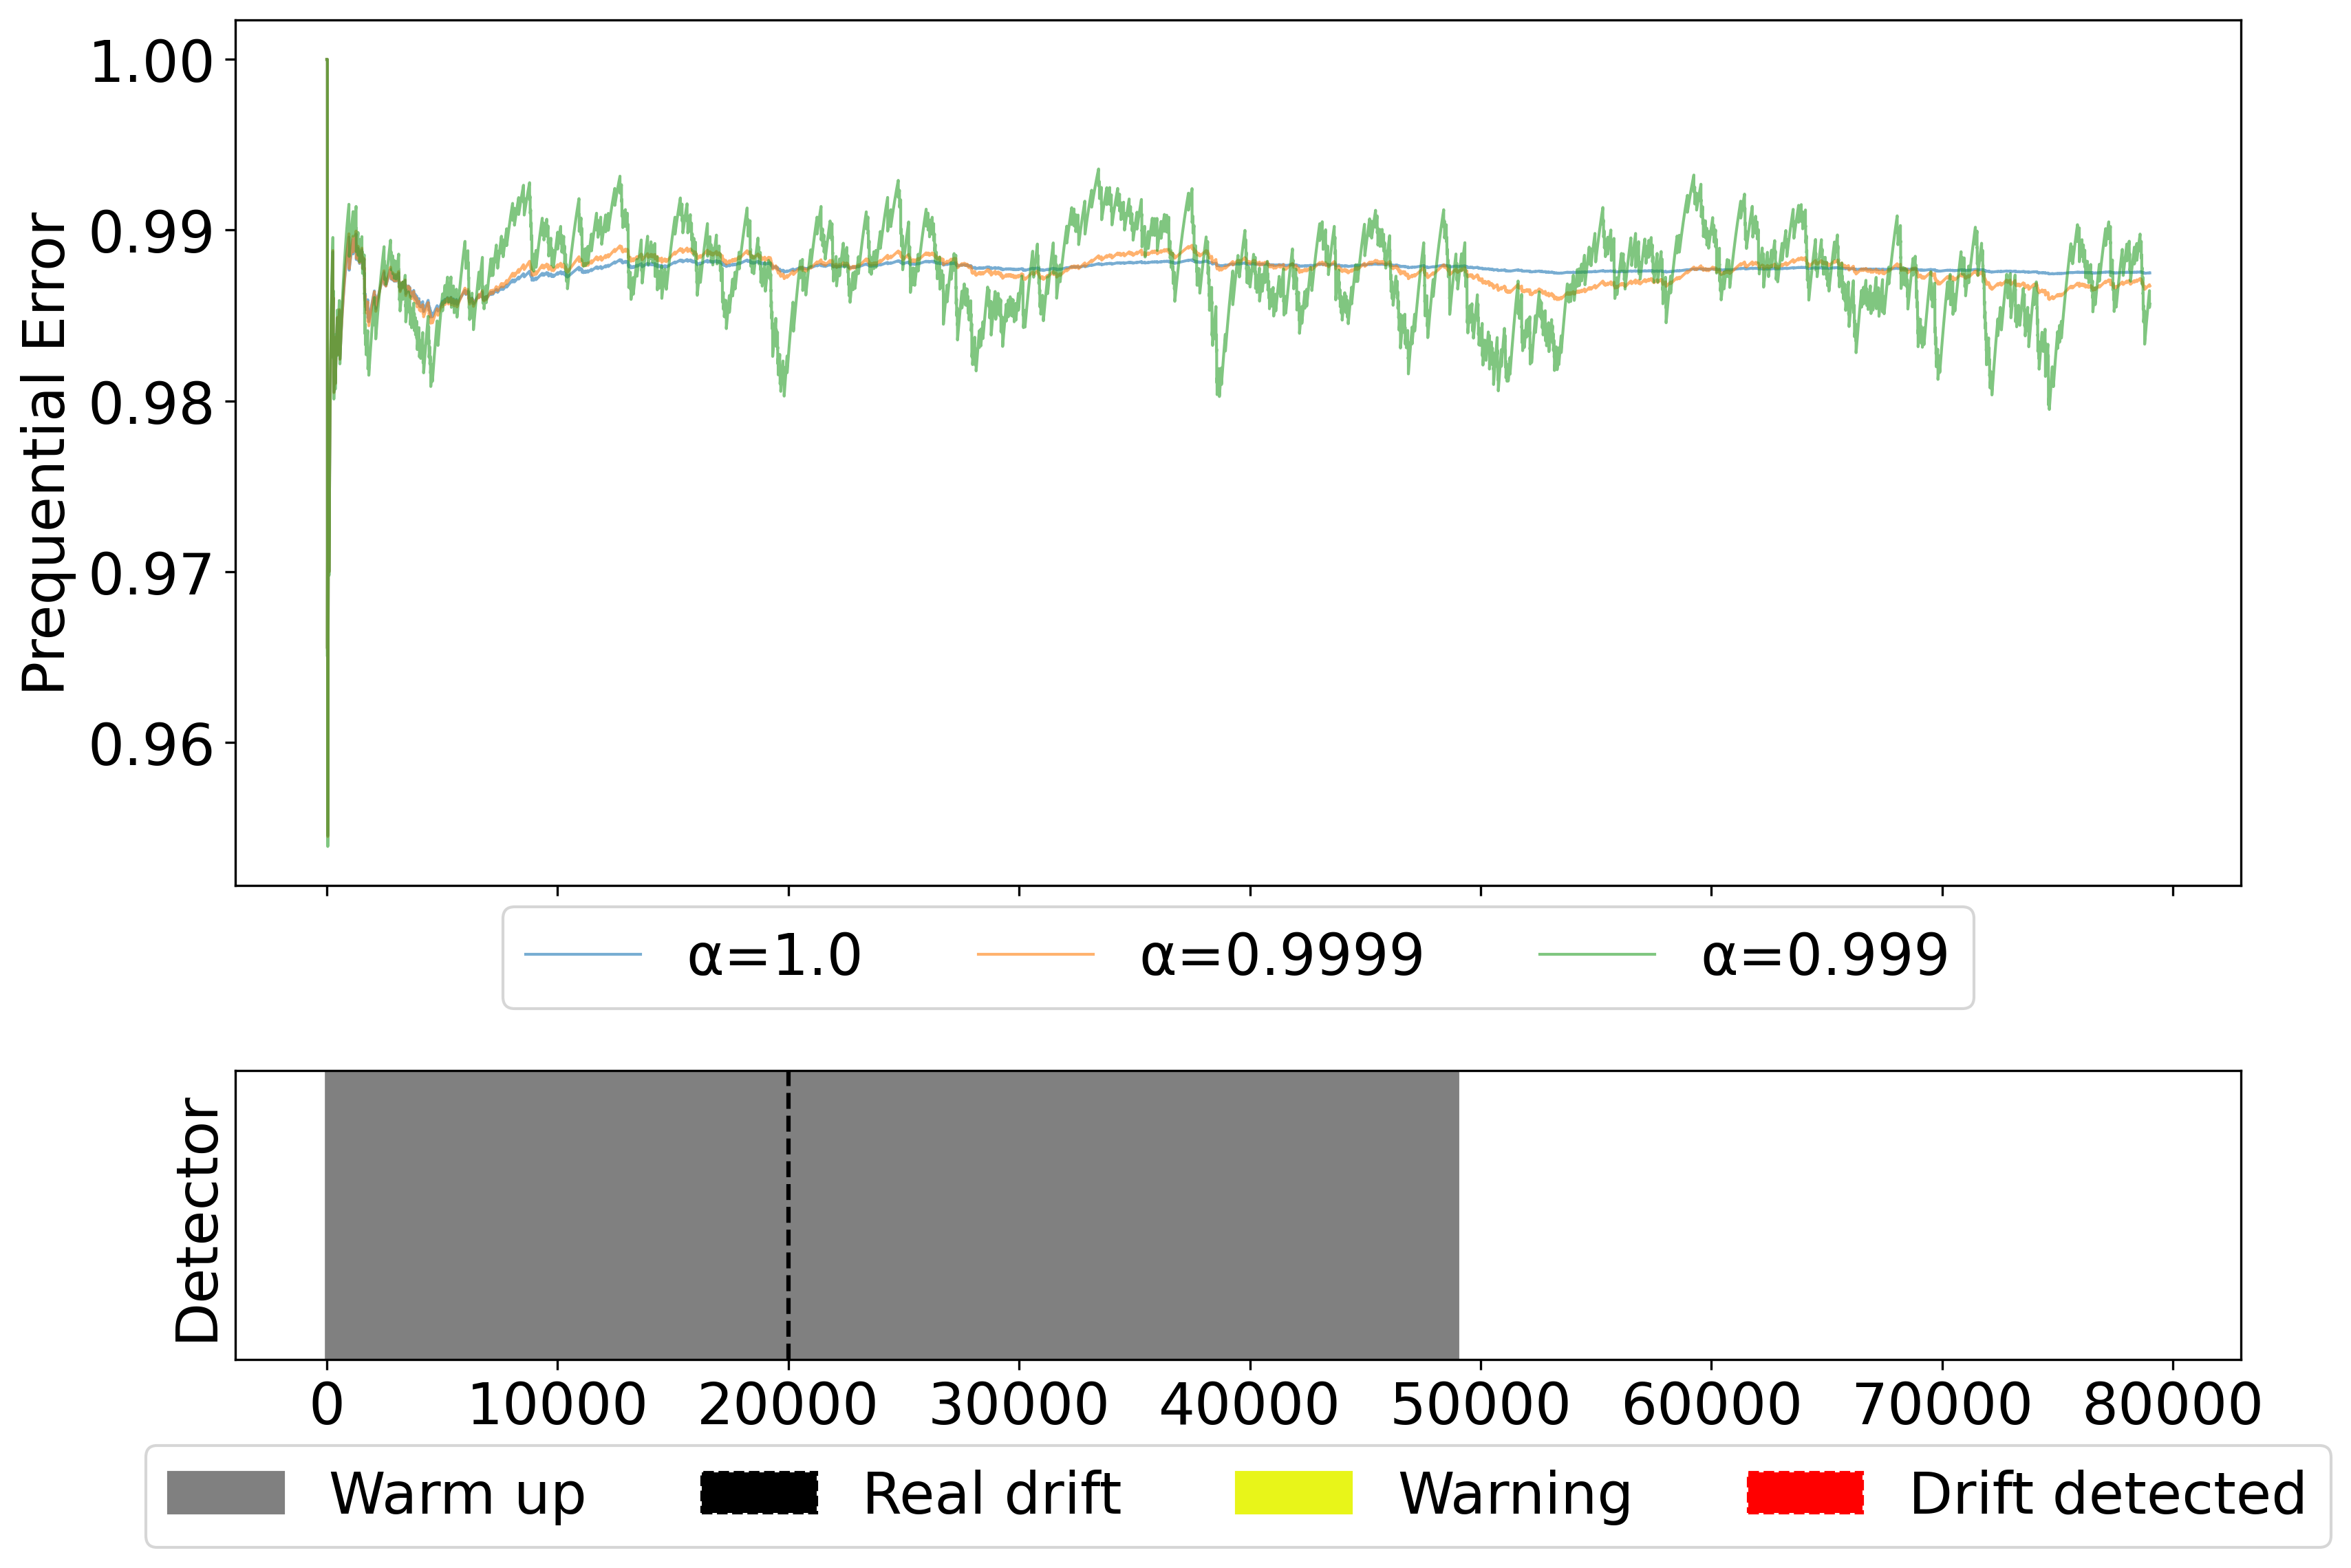

In [17]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from frouros.detectors.concept_drift import DDM, DDMConfig
from frouros.metrics import PrequentialError
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

np.random.seed(seed=31)

# Load and preprocess the data
data = pd.read_csv('EODHD_EURUSD_HISTORICAL_2019_2024_1min.csv').head(100000)
data = data[['close']]
data = np.log(data / data.shift(1))
data = data.dropna()
scaler = StandardScaler()
scaled_result = scaler.fit_transform(data.values.reshape(-1, 1))
data['close'] = pd.Series(scaled_result.flatten())

# Create the target variable using the next day's close price
data['target'] = data['close'].shift(-1).dropna()
data = data.dropna()

# Split the data into features and target
X = data[['close']].values
y = data['target'].values

# Split train (70%) and test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=31)

# Further split train data for warm-up
X_warmup, X_train, y_warmup, y_train = train_test_split(X_train, y_train, train_size=0.7, random_state=31)

# Define and fit model
model = DecisionTreeRegressor(random_state=31)
model.fit(X=X_train, y=y_train)

# Detector configuration and instantiation
config = DDMConfig(
    warning_level=2.0,
    drift_level=3.0,
    min_num_instances=len(X_warmup),  # Minimum number of instances to start checking for drift
)
detector = DDM(config=config)

# Metric to compute accuracy
metrics = [
    PrequentialError(
        alpha=alpha,
        name=f"α={alpha}",
    )
    for alpha in [1.0, 0.9999, 0.999]
]
metrics_historic_detector = {f"{metric.name}": [] for metric in metrics}

def error_scorer(y_true, y_pred):  # Error function
    return 1 - (y_true.item() == y_pred.item())

# Warm-up detector
print(f"Warming up detector with {len(X_warmup)} samples")

for X, y in zip(X_warmup, y_warmup):
    y_pred = model.predict(X.reshape(1, -1))
    error = error_scorer(y_true=y, y_pred=y_pred)
    _ = detector.update(value=error)

    for metric_historic, metric in zip(metrics_historic_detector.keys(), metrics):
        metrics_historic_detector[metric_historic].append(metric(error))

idx_drift, idx_warning = [], []
i = len(X_warmup)
for X, y in zip(X_test, y_test):
    y_pred = model.predict(X.reshape(1, -1))  # Model's prediction
    error = error_scorer(y_true=y, y_pred=y_pred)
    _ = detector.update(value=error)  # Detector's update

    # All the following lines are optional and only used for plotting the whole process
    for metric_historic, metric in zip(metrics_historic_detector.keys(), metrics):
        metrics_historic_detector[metric_historic].append(metric(error))

    status = detector.status
    if status["drift"]:
        # Drift detected
        print(f"Drift detected at index: {i}")
        idx_drift.append(i)
        detector.reset()  # Reset detector
        for metric in metrics:  # Reset metrics
            metric.reset()
        break  # Stop simulation
    elif status["warning"]:
        # Warning zone
        idx_warning.append(i)
    i += 1

plt.rcParams.update({'font.size': 20})

alpha = 0.6
linewidth = 1.0

fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12, 8),
    sharex=True,
    dpi=300,
    gridspec_kw={'height_ratios': [3, 1]},
)

for (metric_name, metric_values), linecolor in zip(
        metrics_historic_detector.items(),
        ["#1f77b4", "#ff7f0e", "#2ca02c"],
):
    ax[0].plot(metric_values,
               color=linecolor,
               linewidth=linewidth,
               alpha=alpha,
               label=metric_name)

drift_color = "red"
drift_linestyle = "--"
warmup_color = "grey"
warning_color = "#e8f519"
real_drift_color = "black"

for idx in range(0, len(X_warmup)):
    ax[1].axvline(x=idx,
                  color=warmup_color,
                  linewidth=linewidth)

for idx in idx_warning:
    ax[1].axvline(x=idx,
                  color=warning_color,
                  linewidth=linewidth)

for idx in idx_drift:
    ax[1].axvline(x=idx,
                  color=drift_color,
                  linestyle=drift_linestyle,
                  linewidth=1.5)

ax[0].set_ylabel("Prequential Error")
ax[0].legend(
    loc="lower center",
    ncol=3,
    bbox_to_anchor=(0.5, -0.175),
    fancybox=True,
)
ax[1].set_yticks([])
ax[1].set_ylabel("Detector")
drift_path = mpatches.Patch(color=drift_color, label="Drift detected", linestyle=drift_linestyle)
warning_path = mpatches.Patch(color=warning_color, label="Warning")
warmup_path = mpatches.Patch(color=warmup_color, label="Warm up")
real_drift_path = mpatches.Patch(color=real_drift_color, label="Real drift", linestyle=drift_linestyle)
ax[1].axvline(x=20000,
              color=real_drift_color,
              linestyle=drift_linestyle,
              linewidth=1.5)
ax[1].legend(
    handles=[warmup_path, real_drift_path, warning_path, drift_path],
    loc="upper center",
    ncol=4,
    bbox_to_anchor=(0.5, -0.2),
    fancybox=True,
)

fig.tight_layout()
plt.show()